## IBM Data Science Capstone Project

#### Introduction

This notebook will try to solve a theoretical business problem using Data Science and Machine Learning, specifically using k-means Clustering.

The Business problem is finding the best neighborhoods for existing and new F&B businesses to open up a restaurant in all of NYC's 5 boroughs. This notebook will focus on New York City as it is a metropolitan city, where the F&B sector is highly competitive.

Many F&B businesses have a very difficult time studying and researching the best location to open up their restaurant. This notebook should give a brief insight on the best neighborhoods to open up a new restaurant in and what type of cuisine would most suit these neighborhoods.

The data that will be used in the report will be from the following sources:

- The list of Boroughs and Neighborhoods from the 'newyork_data.json' file from IBM's server. 
- Geo-coordinates of New York City's Neighborhoods using the Nominatim API from Python's Geopy client. 
- Venues data using the Foursquare API.

### First thing to do is importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Getting the data

### New York City Boroughs and Neighborhoods

The newyork_data json file contains the list of the boroughs and neighborhoods of NYC.

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open ('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [4]:
neighborhoods_data = newyork_data['features']

### Creating a pandas dataframe that will contain the geo-coordinates of the neighborhoods (latitudes and longitudes)

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# instantiaate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


### Getting the geo-coordinates of the neighborhoods using the Nominatim API from Python's Geopy.

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                         'Neighborhood': neighborhood_name,
                                         'Latitude': neighborhood_lat,
                                         'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()),
                                                                  neighborhoods.shape[0]
                                                                  )
     )

The dataframe has 5 boroughs and 306 neighborhoods.


### Create a map of the city using Folium
But first we acquire the goe-coordinates of NYC using Geopy again.

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="NYC_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geo-coordinates of NYC are {}, {}.'.format(latitude,longitude))

The geo-coordinates of NYC are 40.7127281, -74.0060152.


### Now we create the map of NYC and its neighborhoods.

In [9]:
# create map of NYC using latitude and longitude
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='white',
        fill_opacity=0.6,
        parse_html=False).add_to(nyc_map)
    
nyc_map

## 2. Exploring the Neighborhoods of NYC

### First we explore the top venues of the neighborhoods using the Foursquare API
We begin by inputting Foursquare's credentials (which will be removed from the notebook for privacy).

In [45]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'
LIMIT = 100

### Explore the first Neighborhood

In [11]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

### Get the geo-coordinates

In [12]:
neigh_name = neighborhoods.loc [0, 'Neighborhood'] # Neighborhood's name
neigh_lat = neighborhoods.loc[0, 'Latitude'] # Neighborhood's Latitude
neigh_lng = neighborhoods.loc[0, 'Longitude'] # Neighborhood's Longitude

print('Latitude and Longitude of {} are {}, {}.'.format(neigh_name,
                                                       neigh_lat,
                                                       neigh_lng))

Latitude and Longitude of Wakefield are 40.89470517661, -73.84720052054902.


### Get the top 100 venues in the first neighborhood within a radius of 1000 meters, using the Foursquare API.

In [13]:
LIMIT = 100 # limit of number of venues retrieved by the Foursquare API
radius = 1000 

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neigh_lat,
    neigh_lng,
    radius,
    LIMIT)
url # to display url

'https://api.foursquare.com/v2/venues/explore?&client_id=EY2XJIIOXM2SBROS3FIE045R2JXP0YUQXVVV2VKPQSCMXQ2J&client_secret=5WD4GDTCENSX4OFYBPULPQHSMFZK1WWT3A24GUD4C0TQCYUL&v=20180605&ll=40.89470517661,-73.84720052054902&radius=1000&limit=100'

### Get the json file of the top venues.

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '604332bb690fe03785302551'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 48,
  'suggestedBounds': {'ne': {'lat': 40.903705185610015,
    'lng': -73.83531662200086},
   'sw': {'lat': 40.88570516760999, 'lng': -73.85908441909719}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'ln

### Defining a function that extracts the category of the venue.

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Cleaning up the data.

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Ripe Kitchen & Bar,Caribbean Restaurant,40.898152,-73.838875
2,Ali's Roti Shop,Caribbean Restaurant,40.894036,-73.856935
3,Jackie's West Indian Bakery,Caribbean Restaurant,40.889283,-73.843310
4,Rite Aid,Pharmacy,40.896649,-73.844846
5,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
6,Jimbo's,Burger Joint,40.891740,-73.858226
7,Walgreens,Pharmacy,40.896528,-73.844700
8,Rite Aid,Pharmacy,40.889062,-73.842993
9,Subway,Sandwich Place,40.890468,-73.849152


In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

48 venues were returned by Foursquare.


### Now its time to explore the top venues of other neighborhoods in NYC by defining a function 'getNearbyVenues' as below:

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Acquiring the data

In [19]:
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [20]:
print(nyc_venues.shape)
nyc_venues.head()

(20571, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy


### Counting how many venues were retrieved from other neighborhoods.

In [21]:
nyc_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,60,60,60,60,60,60
Annadale,17,17,17,17,17,17
Arden Heights,18,18,18,18,18,18
Arlington,23,23,23,23,23,23
Arrochar,26,26,26,26,26,26


### Finding out how many distinct venue categories were found.

In [22]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 482 uniques categories.


## 3. One Hot Encoding to analyze the neighborhoods.

In [23]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mob

In [24]:
nyc_onehot.shape

(20571, 482)

### Now we group the data by neighborhood and calculate the mean of occurence frequency of each category

In [25]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellan

### Shape of the grouped data frame.

In [26]:
nyc_grouped.shape

(302, 482)

### Now we can find the top 5 most common venues in each neighborhood.

In [27]:
num_top_venues = 5

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0         Pizza Place  0.12
1          Donut Shop  0.07
2       Deli / Bodega  0.05
3            Pharmacy  0.05
4  Mexican Restaurant  0.05


----Annadale----
                 venue  freq
0           Restaurant  0.12
1                Trail  0.12
2         Home Service  0.12
3  American Restaurant  0.12
4       Cosmetics Shop  0.06


----Arden Heights----
                venue  freq
0                Park  0.11
1             Dog Run  0.06
2  Italian Restaurant  0.06
3                 Spa  0.06
4                Food  0.06


----Arlington----
              venue  freq
0          Bus Stop  0.17
1     Deli / Bodega  0.13
2    Hardware Store  0.09
3    Discount Store  0.09
4  Department Store  0.04


----Arrochar----
                venue  freq
0            Bus Stop  0.12
1       Deli / Bodega  0.08
2               Beach  0.08
3      Baseball Field  0.08
4  Italian Restaurant  0.08


----Arverne----
           venue  freq
0          Beach  0.09
1  


----Coney Island----
                          venue  freq
0  Theme Park Ride / Attraction  0.15
1                    Theme Park  0.10
2                   Pizza Place  0.05
3                         Beach  0.04
4                   Bus Station  0.03


----Corona----
                venue  freq
0          Food Truck  0.05
1         Pizza Place  0.04
2  Mexican Restaurant  0.04
3  Chinese Restaurant  0.04
4       Deli / Bodega  0.03


----Country Club----
            venue  freq
0   Deli / Bodega  0.08
1  Sandwich Place  0.06
2          Bakery  0.05
3            Bank  0.05
4     Pizza Place  0.05


----Crown Heights----
                             venue  freq
0                             Café  0.07
1             Caribbean Restaurant  0.06
2                      Pizza Place  0.05
3  Southern / Soul Food Restaurant  0.05
4                      Coffee Shop  0.04


----Cypress Hills----
                       venue  freq
0       Fast Food Restaurant  0.11
1  Latin American Restaurant  0.08

              venue  freq
0            Lounge  0.07
1              Park  0.07
2  Baseball Stadium  0.07
3      Burger Joint  0.05
4             Plaza  0.05


----Highland Park----
                       venue  freq
0                Pizza Place  0.12
1  Latin American Restaurant  0.09
2             Ice Cream Shop  0.09
3       Fast Food Restaurant  0.09
4        Fried Chicken Joint  0.06


----Hillcrest----
               venue  freq
0        Bus Station  0.06
1        Coffee Shop  0.04
2     Ice Cream Shop  0.04
3  Mobile Phone Shop  0.04
4     Sandwich Place  0.03


----Hollis----
                 venue  freq
0          Pizza Place  0.10
1        Deli / Bodega  0.06
2           Donut Shop  0.06
3  Fried Chicken Joint  0.06
4        Shopping Mall  0.06


----Holliswood----
                venue  freq
0  Chinese Restaurant  0.08
1          Playground  0.06
2                Bank  0.04
3       Shopping Mall  0.04
4         Pizza Place  0.04


----Homecrest----
                venue  freq


                 venue  freq
0   Italian Restaurant  0.07
1  American Restaurant  0.04
2          Pizza Place  0.03
3   Mexican Restaurant  0.03
4                 Bank  0.03


----New Dorp Beach----
                 venue  freq
0           Kids Store  0.04
1  American Restaurant  0.04
2       Discount Store  0.03
3                 Bank  0.03
4      Supplement Shop  0.03


----New Lots----
                  venue  freq
0         Deli / Bodega  0.10
1  Fast Food Restaurant  0.08
2           Pizza Place  0.07
3   Fried Chicken Joint  0.07
4         Grocery Store  0.05


----New Springville----
                    venue  freq
0             Coffee Shop  0.07
1                Pharmacy  0.05
2                Bus Stop  0.05
3  Furniture / Home Store  0.05
4          Sandwich Place  0.05


----Noho----
                 venue  freq
0  Japanese Restaurant  0.06
1         Cocktail Bar  0.04
2          Coffee Shop  0.04
3                Hotel  0.04
4   Seafood Restaurant  0.03


----North Corona---

                  venue  freq
0           Pizza Place  0.14
1                  Park  0.08
2  Caribbean Restaurant  0.08
3           Supermarket  0.05
4        Discount Store  0.05


----South Ozone Park----
               venue  freq
0               Park  0.08
1              Hotel  0.08
2         Donut Shop  0.08
3      Deli / Bodega  0.08
4  Indian Restaurant  0.05


----South Side----
         venue  freq
0  Coffee Shop  0.07
1          Bar  0.07
2  Pizza Place  0.06
3     Wine Bar  0.05
4       Bakery  0.04


----Springfield Gardens----
           venue  freq
0  Deli / Bodega  0.10
1            Gym  0.07
2    Bus Station  0.07
3           Park  0.07
4     Donut Shop  0.07


----Spuyten Duyvil----
            venue  freq
0            Park  0.09
1        Pharmacy  0.09
2     Pizza Place  0.08
3  Sandwich Place  0.06
4           Diner  0.04


----St. Albans----
                  venue  freq
0  Caribbean Restaurant  0.25
1           Pizza Place  0.10
2                  Café  0.05
3   Fr

### Define a function that returns most common venues

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Put the data into a data frame.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Donut Shop,Sandwich Place,Deli / Bodega,Caribbean Restaurant,Fast Food Restaurant,Mexican Restaurant,Pharmacy,Fried Chicken Joint,Food
1,Annadale,American Restaurant,Trail,Home Service,Restaurant,Pizza Place,Diner,Train Station,Park,Pub,Liquor Store
2,Arden Heights,Park,Italian Restaurant,Dog Run,Sushi Restaurant,Optical Shop,Food,Bus Stop,Spa,Gift Shop,Mexican Restaurant
3,Arlington,Bus Stop,Deli / Bodega,Hardware Store,Discount Store,American Restaurant,Check Cashing Service,Snack Place,Fast Food Restaurant,Coffee Shop,Donut Shop
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Baseball Field,Beach,Bagel Shop,Mediterranean Restaurant,Middle Eastern Restaurant,Nail Salon,Outdoors & Recreation


## Machine Learning
### We will be using a Clustering algorithm using K-means to cluster the most common venues in NYC
To find out the optimal number of clusters we will first use the Elbow Method, and we will create a graph of it as well.

In [30]:
import sklearn.cluster as cluster

In [31]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

K = range(1,15)
wss = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k, init="k-means++", random_state=1)
    kmeans = kmeans.fit(nyc_grouped_clustering)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [32]:
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})

### Graph the Elbow Method

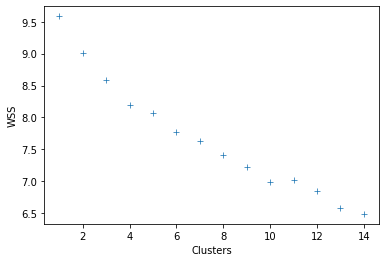

In [33]:
import seaborn as sns

sns.scatterplot(x= 'Clusters', y = 'WSS', data = mycenters, marker = "+")

As we can see from the above elbow method, it is not clear for us which is the best number of clusters, and this could happen with the elbow method. An alternative method would be the Silhouette Scores, which should give a more accurate way to select the number of clusters. The silhouette score gives a score between 0 and 1, the higher the more accurate.

### Create a graph for the Silhouette Score

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [36]:
max_range = 10

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = nyc_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 10).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

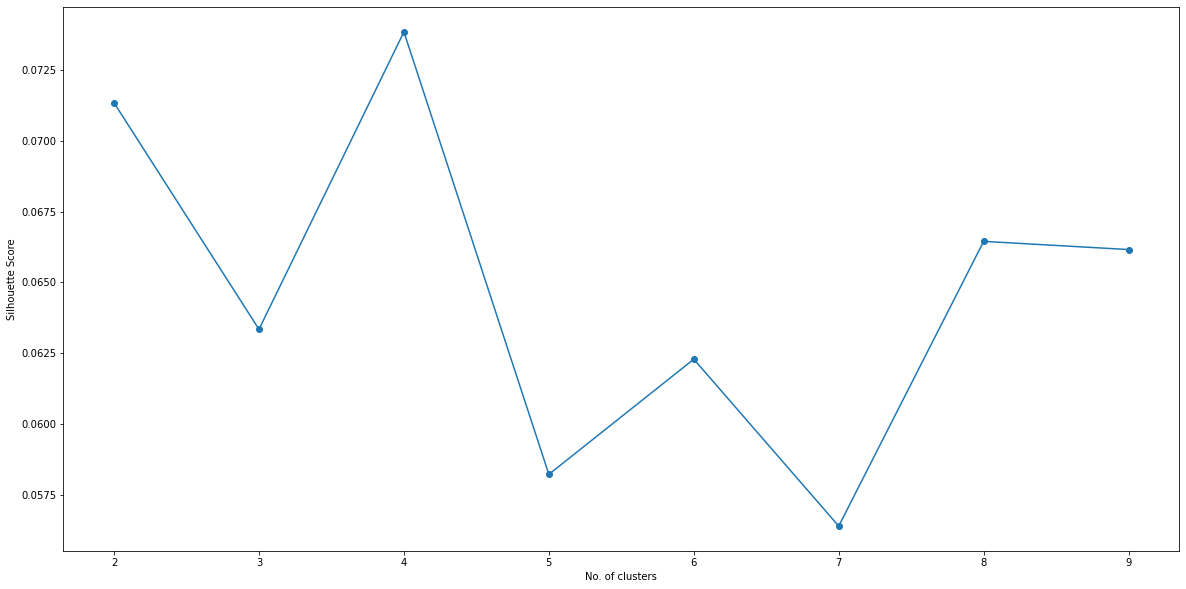

In [37]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

### Based on the graph shown above, the optimal number of clusters is 4, and we run the K-means clustering with 4 as the number of clusters.

In [38]:
# run k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 2, 1, 3, 2, 3, 1], dtype=int32)

### Now we create a new dataframe that contains the cluster label as well as top 10 venues of each neighborhood.

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods = neighborhoods.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

neighborhoods.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1,Pharmacy,Caribbean Restaurant,Supermarket,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Bank,Pizza Place,Bakery,Bus Station
1,Bronx,Co-op City,40.874294,-73.829939,1,Pizza Place,Department Store,Mobile Phone Shop,Shopping Mall,Shoe Store,Pharmacy,Clothing Store,Bakery,Liquor Store,Mattress Store
2,Bronx,Eastchester,40.887556,-73.827806,1,Caribbean Restaurant,Shopping Mall,Diner,Fast Food Restaurant,Gas Station,Supplement Shop,Grocery Store,Pharmacy,Donut Shop,Discount Store
3,Bronx,Fieldston,40.895437,-73.905643,1,Deli / Bodega,Bus Station,Pizza Place,Bar,Plaza,Sandwich Place,Park,Mexican Restaurant,Bank,Chinese Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,3,Bank,Pizza Place,Bar,Park,Diner,Deli / Bodega,Japanese Restaurant,Coffee Shop,Health & Beauty Service,Bagel Shop


### Create a map to visualize the clusters

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining Clusters

### Cluster 1

In [41]:
neighborhoods.loc[neighborhoods['Cluster Labels'] == 0, neighborhoods.columns[[1] + list(range(5, neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
85,Sea Gate,Beach,Supermarket,American Restaurant,Pharmacy,Park,Donut Shop,Chinese Restaurant,Bus Stop,Video Store,Spa
172,Breezy Point,Surf Spot,American Restaurant,Beach,Monument / Landmark,Park,Trail,Deli / Bodega,Exhibit,Factory,Falafel Restaurant
178,Rockaway Beach,Beach,Bar,Pharmacy,Boat or Ferry,Latin American Restaurant,Ice Cream Shop,Pizza Place,Eastern European Restaurant,Arepa Restaurant,Supermarket
179,Neponsit,Beach,Spa,Deli / Bodega,Pub,Mexican Restaurant,Italian Restaurant,Restaurant,Harbor / Marina,Bakery,Boutique
190,Belle Harbor,Beach,Pub,Donut Shop,Bakery,Mexican Restaurant,Bagel Shop,Chinese Restaurant,Harbor / Marina,Pharmacy,Smoke Shop
191,Rockaway Park,Beach,Pizza Place,Donut Shop,Liquor Store,Bagel Shop,Bar,Pharmacy,Deli / Bodega,Pub,Supermarket
302,Hammels,Beach,Surf Spot,Donut Shop,Fast Food Restaurant,Coffee Shop,Pizza Place,Taco Place,Bar,Supermarket,Wine Bar


### Cluster 2

In [42]:
neighborhoods.loc[neighborhoods['Cluster Labels'] == 1, neighborhoods.columns[[1] + list(range(5, neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Caribbean Restaurant,Supermarket,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Bank,Pizza Place,Bakery,Bus Station
1,Co-op City,Pizza Place,Department Store,Mobile Phone Shop,Shopping Mall,Shoe Store,Pharmacy,Clothing Store,Bakery,Liquor Store,Mattress Store
2,Eastchester,Caribbean Restaurant,Shopping Mall,Diner,Fast Food Restaurant,Gas Station,Supplement Shop,Grocery Store,Pharmacy,Donut Shop,Discount Store
3,Fieldston,Deli / Bodega,Bus Station,Pizza Place,Bar,Plaza,Sandwich Place,Park,Mexican Restaurant,Bank,Chinese Restaurant
6,Marble Hill,Park,Pizza Place,Mexican Restaurant,Café,Donut Shop,Spanish Restaurant,Sandwich Place,Grocery Store,Scenic Lookout,Supermarket
7,Woodlawn,Pub,Bar,Deli / Bodega,Pizza Place,Bakery,Discount Store,Donut Shop,Bank,Baseball Field,Fast Food Restaurant
8,Norwood,Pizza Place,Bank,Donut Shop,Fast Food Restaurant,Mexican Restaurant,Pharmacy,Park,Sandwich Place,Gym,Mobile Phone Shop
9,Williamsbridge,Pizza Place,Caribbean Restaurant,Supermarket,Sandwich Place,Bakery,Spa,Convenience Store,Pharmacy,Fried Chicken Joint,Restaurant
10,Baychester,Clothing Store,Pizza Place,Pharmacy,Department Store,Donut Shop,Shopping Mall,Deli / Bodega,Discount Store,Sandwich Place,Fried Chicken Joint
11,Pelham Parkway,Pizza Place,Italian Restaurant,Ice Cream Shop,Deli / Bodega,Chinese Restaurant,Bank,Sandwich Place,Donut Shop,Bakery,Burger Joint


In [43]:
neighborhoods.loc[neighborhoods['Cluster Labels'] == 2, neighborhoods.columns[[1] + list(range(5, neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,City Island,Harbor / Marina,Seafood Restaurant,Boat or Ferry,Italian Restaurant,Bar,Thrift / Vintage Store,American Restaurant,Music Venue,French Restaurant,Bank
16,Fordham,Italian Restaurant,Pizza Place,Spanish Restaurant,Deli / Bodega,Shoe Store,Mobile Phone Shop,Diner,Coffee Shop,Supplement Shop,Dessert Shop
27,Clason Point,Pool,Boat or Ferry,Event Space,Discount Store,Gym / Fitness Center,Park,Wings Joint,Bus Stop,Farm,Falafel Restaurant
28,Throgs Neck,Italian Restaurant,Deli / Bodega,Donut Shop,Pizza Place,Harbor / Marina,American Restaurant,Asian Restaurant,Coffee Shop,Trail,Bookstore
34,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Shoe Store,Zoo,Dessert Shop,Latin American Restaurant,Café,Garden
37,Pelham Bay,Italian Restaurant,Deli / Bodega,Fast Food Restaurant,Sandwich Place,Pizza Place,Bank,Bakery,Convenience Store,Donut Shop,Rental Car Location
38,Schuylerville,Italian Restaurant,Pizza Place,Bar,Diner,American Restaurant,Bank,Donut Shop,Sandwich Place,Mexican Restaurant,Pharmacy
39,Edgewater Park,Italian Restaurant,Pizza Place,Deli / Bodega,Bar,Donut Shop,Mobile Phone Shop,Diner,Park,Pharmacy,Sandwich Place
77,Manhattan Beach,Italian Restaurant,Turkish Restaurant,Seafood Restaurant,Sandwich Place,Dessert Shop,Eastern European Restaurant,Bus Stop,Pizza Place,Restaurant,Harbor / Marina
82,Gerritsen Beach,Donut Shop,Ice Cream Shop,Seafood Restaurant,Deli / Bodega,Pizza Place,Bar,Grocery Store,Russian Restaurant,Convenience Store,Bagel Shop


In [44]:
neighborhoods.loc[neighborhoods['Cluster Labels'] == 3, neighborhoods.columns[[1] + list(range(5, neighborhoods.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,Bank,Pizza Place,Bar,Park,Diner,Deli / Bodega,Japanese Restaurant,Coffee Shop,Health & Beauty Service,Bagel Shop
5,Kingsbridge,Pizza Place,Mexican Restaurant,Sandwich Place,Bar,Diner,Donut Shop,Coffee Shop,Pharmacy,Bank,Park
19,High Bridge,Lounge,Baseball Stadium,Park,Plaza,Burger Joint,Bar,BBQ Joint,Beer Bar,Caribbean Restaurant,Liquor Store
24,Hunts Point,Park,Bakery,Market,Paintball Field,Travel & Transport,Gourmet Shop,Farmers Market,Seafood Restaurant,Mexican Restaurant,Home Service
46,Bay Ridge,Pizza Place,Spa,Italian Restaurant,Coffee Shop,Bagel Shop,Chinese Restaurant,Cosmetics Shop,Greek Restaurant,American Restaurant,Café
48,Sunset Park,Bakery,Mexican Restaurant,Pizza Place,Chinese Restaurant,Bank,Latin American Restaurant,Ice Cream Shop,Asian Restaurant,Sandwich Place,Dumpling Restaurant
49,Greenpoint,Coffee Shop,Cocktail Bar,Bar,Pizza Place,Café,Yoga Studio,French Restaurant,Bagel Shop,Polish Restaurant,Record Shop
51,Brighton Beach,Grocery Store,Beach,Restaurant,Bakery,Eastern European Restaurant,Russian Restaurant,Aquarium,Bank,Café,Sushi Restaurant
52,Sheepshead Bay,Italian Restaurant,Sushi Restaurant,Russian Restaurant,Turkish Restaurant,Pizza Place,Dessert Shop,Café,Bagel Shop,Grocery Store,Bank
54,Flatbush,Pizza Place,Caribbean Restaurant,Coffee Shop,Mexican Restaurant,Bar,Middle Eastern Restaurant,Ice Cream Shop,Mobile Phone Shop,Lounge,Thai Restaurant


## 4. Conclusion

After implementing the k-means clustering algorithm, we can see the following for each cluster:

#### Cluster 1:
In the first cluster we can see that there aren't many restaurants in the top spots of common venues in these neighborhoods, and also there isn't a wide variety of cuisine options in the top spots with the most common options being: American restaurants, Donut shops and Pizza places. Furthermore, we can also see that beaches are quite common in these neighborhoods, making it an ideal option for some types of cuisine like seafood, casual dining, and other types of laid back cuisines like lounges.

#### Cluster 2:
In cluster 2 we can see that there are many restaurants in the top 3 spots of most common venues in the neighborhoods, like Carribean restaurants, Donut shops, Chinese restaurants, etc... with Pizza places being quite common. Which can also mean that competition could be high in these neighborhoods. We can also see from the map, that these neighborhoods are mainly in Brooklyn, Queen and The Bronx, and that it is one of the largest clusters where F&B businesses are very common and diverse. Furthermore, we can see that parks occupy a top spot in a couple of neighborhoods, which could give us an idea that these neighborhoods are more family oriented, where Family Diners could do well. The neighborhoods in this cluster could be ideal for fast food outlets, family diners, as well as foreign cuisines given the varse diversity of the neighborhoods.
   
#### Cluster 3:
In this cluster, we can note that Italian restaurants and pizza places are quite common in these neighborhoods. This could also mean that other types of cuisines could have a good chance there, but this could also mean that the demographic in these neighborhoods prefers these types of cuisines, and that is why we see many of those in these areas. When we look at the map of clusters, we see most of the points are in Staten Island, where the majority of residents are Italian Americans. This cluster could be ideal for a lot of different cuisines and specifically American cuisines given that it has some musuems, hotels and other touristy attractions, and also casual or family diners since its neighborhoods have common parks and other family attractions, and finally, it can be ideal for seafood concepts as some of the neighborhoods have Marinas and Harbors as the most common venues.

#### Cluster 4:
If we look at the top most common venues in this cluster, we can find out that it has quite a variety of famous venues from Italian, to Latin American, to American and also Asian cuisines. And looking at the clusters map, we can see that the points of this cluster are mainly in Manhattan, which has a very diverse and competitve market. In this cluster, we can see that coffee shops, bars, cafes and parks are some of the more common venues in the neighborhoods. Making these neighborhoods ideal for such type of cuisines.
